In [1]:
import os
os.chdir('..')

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from three_tank_data.dataset import ThreeTankDataSet
from torch.utils.data import DataLoader

In [4]:
dataset = ThreeTankDataSet(debug=True)

In [5]:
batch_size = 1000
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=24)

In [6]:
from sindy_autoencoder_cps.lightning_module import SINDyAutoencoder
import yaml
# MODEL_VERSION = 'freq_and_phase'
MODEL_VERSION = 'version_1'

hparams_path = f'./lightning_logs/{MODEL_VERSION}/hparams.yaml'
with open(hparams_path, 'r') as stream:
        hparam_dct = yaml.safe_load(stream)
ckpt_file_name = os.listdir(f'./lightning_logs/{MODEL_VERSION}/checkpoints/')[-1]
ckpt_file_path = f'./lightning_logs/{MODEL_VERSION}/checkpoints/{ckpt_file_name}'
model = SINDyAutoencoder.load_from_checkpoint(ckpt_file_path)
model

Global seed set to 12354


SINDyAutoencoder(
  (activation_function): Tanh()
  (phi_x): Encoder(
    (fc1): Linear(in_features=10000, out_features=1028, bias=True)
    (fc2): Linear(in_features=1028, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=64, bias=True)
    (fc5): Linear(in_features=64, out_features=3, bias=True)
    (activation): Tanh()
  )
  (psi_z): Decoder(
    (fc1): Linear(in_features=3, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=1028, bias=True)
    (fc5): Linear(in_features=1028, out_features=10000, bias=True)
    (activation): Tanh()
  )
)

In [7]:
model.SINDyLibrary.device

'cuda:0'

In [8]:
batches = iter(dataloader)

In [9]:
x, xdot, idxs = batches.next()
print(f'shape x: {x.shape},   shape xdot: {xdot.shape}')

shape x: torch.Size([1000, 10000]),   shape xdot: torch.Size([1000, 10000])


In [10]:
x_hat, xdot_hat, z, zdot, zdot_hat = model.cuda()(x.cuda(), xdot.cuda())

In [11]:
#select random sample and compare original and recostruction
sample = 0
# sample = 477
x_sample = x[sample, :].cpu().detach().numpy()
xhat_sample = x_hat[sample, :].cpu().detach().numpy()
z_sample = z[sample, :].cpu().detach().numpy()
xdot_sample = xdot[sample, :].cpu().detach().numpy()
xdot_hat_sample = xdot_hat[sample, :].cpu().detach().numpy()
zdot_sample = zdot[sample, :].cpu().detach().numpy()
zdot_hat_sample = zdot_hat[sample, :].cpu().detach().numpy()
idx_sample = idxs[sample]

In [12]:
# fig = make_subplots(rows=2, cols=2,
#                     horizontal_spacing=0.01, 
#                     shared_yaxes=True)
# fig.add_trace(go.Heatmap(z=x_sample.reshape(const.PICTURE_SIZE, const.PICTURE_SIZE), colorscale=[[0, 'rgb(255, 255, 255)'], [1, 'rgb(0,0,255)']]), 1, 1)
# fig.add_trace(go.Heatmap(z=xhat_sample.reshape(const.PICTURE_SIZE, const.PICTURE_SIZE), colorscale=[[0, 'rgb(255, 255, 255)'], [1, 'rgb(0,0,255)']]), 1, 2)
# fig.add_trace(go.Heatmap(z=xdot_sample.reshape(const.PICTURE_SIZE, const.PICTURE_SIZE), colorscale=[[0, 'rgb(255, 255, 255)'], [1, 'rgb(0,0,255)']]), 2, 1)
# fig.add_trace(go.Heatmap(z=xdot_hat_sample.reshape(const.PICTURE_SIZE, const.PICTURE_SIZE), colorscale=[[0, 'rgb(255, 255, 255)'], [1, 'rgb(0,0,255)']]), 2, 2)
# # fig.add_trace(go.Image(z=img), 1, 2)

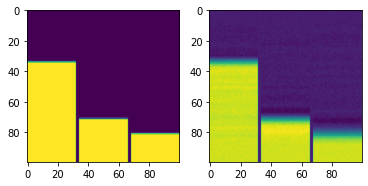

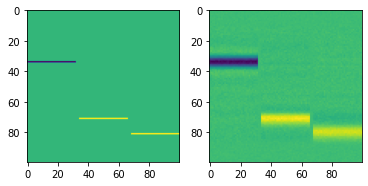

In [13]:
import matplotlib.pyplot as plt
import constants as const
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_sample.reshape(const.PICTURE_SIZE, const.PICTURE_SIZE))
axarr[1].imshow(xhat_sample.reshape(const.PICTURE_SIZE, const.PICTURE_SIZE))
f, axarr = plt.subplots(1,2)
axarr[0].imshow(xdot_sample.reshape(const.PICTURE_SIZE, const.PICTURE_SIZE))
axarr[1].imshow(xdot_hat_sample.reshape(const.PICTURE_SIZE, const.PICTURE_SIZE))

In [14]:
zdot_sample

array([-0.02542707, -0.00751615, -0.16853103], dtype=float32)

In [15]:
zdot_hat_sample

array([-0.03493907, -0.01454775, -0.1861687 ], dtype=float32)

In [16]:
XI = model.XI.cpu().detach().numpy()
XI.max()

0.13227914

In [17]:
import pandas as pd

In [18]:
df_XI = pd.DataFrame(XI, columns=['z0_dot_hat', 'z1_dot_hat', 'z2_dot_hat'])
df_XI.index=model.SINDyLibrary.feature_names

In [19]:
import plotly.express as px
print(model.SINDyLibrary.feature_names)
px.imshow(df_XI.abs())

['z0*z1', 'z0*z2', 'z1*z2', 'sign(z0-z1)*sqrt(|z0-z1|)', 'sign(z0-z2)*sqrt(|z0-z2|)', 'sign(z1-z2)*sqrt(|z1-z2|)']


In [20]:
dataset

In [21]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

fig = make_subplots(rows=2, cols=3, shared_xaxes=True)

for i in range(3):
    fig.add_trace(go.Scatter(x=np.array(range(z.shape[0])),
                       y=z[:, i].cpu().detach().numpy(),
                      mode='markers', name=f'z{i}',
                             marker_color='blue', opacity=.5), row=1, col=1+i,
                    )
for i in range(3):
    fig.add_trace(go.Scatter(x=np.array(range(z.shape[0])),
                       y=zdot_hat[:, i].cpu().detach().numpy(),
                      mode='markers', name=f'zdot_hat{i}',
                            marker_color='blue', opacity=.4), row=2, col=1+i)
for i in range(3):
    fig.add_trace(go.Scatter(x=np.array(range(z.shape[0])),
                       y=zdot[:, i].cpu().detach().numpy(),
                      mode='markers', name=f'zdot{i}',
                             marker_color='green', opacity=.5), row=2, col=1+i)



fig.update_layout(height=600, width=1200, title_text="Side By Side Subplots")
fig.show()

In [22]:
z_real = dataset.df.iloc[idxs][const.Z_COL_NAMES]
fig = make_subplots(rows=2, cols=3, shared_xaxes=True)

for i in range(3):
    fig.add_trace(go.Scatter(x=np.array(range(z.shape[0])),
                       y=z_real.values[:, i],
                      mode='markers', name=f'z_real{i}',
                             marker_color='blue', opacity=.5), row=1, col=1+i)
for i,j in enumerate([2, 0, 1]):
    fig.add_trace(go.Scatter(x=np.array(range(z.shape[0])),
                   y=z[:, i].cpu().detach().numpy(),
                  mode='markers', name=f'z{i}',
                         marker_color='green', opacity=.5), row=2, col=1+j,
                )


fig.update_layout(height=600, width=1200, title_text="Side By Side Subplots")
fig.show()

In [23]:
z_real = dataset.df.iloc[idxs][const.Z_COL_NAMES]
fig = make_subplots(rows=2, cols=3)

for real, pred in zip([0, 1, 2], [2, 1, 0]):
    fig.add_trace(go.Scatter(x=z_real.values[:, real],
                       y=z[:, pred].cpu().detach().numpy(),
                      mode='markers', name=f'z_real{i}',
                             marker_color='blue', opacity=.5), row=1, col=1+real)


fig.update_layout(height=600, width=1200, title_text="Side By Side Subplots")
fig.show()

In [24]:
model.XI_coefficient_mask

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')